In [10]:
import numpy as np
import scipy.io.wavfile as wavf
import scipy.signal
import scipy.fft
import matplotlib.pyplot as plt
from glob import glob
import os

In [2]:
def batch_windowed_fft(mic_array_data: np.ndarray, fs: int):
    """Compute the FFT with Hann window of a microphone array's data in batch.

    Input:
    - mic_data: Mic array data, ndarray of shape (N, L), where N is the number
    of microphones and L is the data's sample length. The whole data for each
    microphone is treated as one FFT frame, and this is the difference between
    this function and batch_stft().
    - fs: sampling rate.
    - frame_time: time of one FFT frame, unit: s. (i.e. 0.025 denotes 25 ms)

    Returns:
    - f_FFT: array of sampling frequencies corresponds to each FFT bin.
    - fft_data: Result of the STFT. An ndarray of shape (N, L'), where N is the
    number of microphones and L' is the FFT length.
    """
    window = scipy.signal.get_window('hann', mic_array_data.shape[1])
    # Use orthogonal norm so that the scale of fft_data is roughly independent
    # of the length of input.
    fft_data = scipy.fft.rfft(mic_array_data * window, norm='ortho')
    f_FFT = np.linspace(0, fs / 2, mic_array_data.shape[1] // 2 + 1)
    # Somehow rfft()'s return type is float64 and complex128, so we need to
    # manually convert it to float32 and complex64.
    return f_FFT.astype(np.float32), fft_data.astype(np.complex64)

def normalize_float(mic_data: np.ndarray, gain: float = 1.0):
    """Normalize microphone's data by removing DC offset and adding gain.

    The input data type is np.int16, and the output data type is np.float32.
    The input data has shape (mic_num, N), where mic_num is the number of
    microphones and N is the number of samples.  Also, the data range will be
    normalized from [-32768, 32767] to [-1, 1).
    """
    dtype = mic_data.dtype
    mic_data = (mic_data - np.mean(mic_data, axis=1, keepdims=True)) * gain
    # Manually clip the data to prevent overflow.
    mic_data = np.clip(mic_data, np.iinfo(dtype).min, np.iinfo(dtype).max)
    # Normalize data range.
    mic_data /= (np.iinfo(dtype).max + 1.0)

    return mic_data.astype(np.float32)

In [16]:
os.path.split('npy_overlapping\\Separated_Cello_Clarinet.npy')[-1].split('.')[0]

'Separated_Cello_Clarinet'

In [19]:
npy_root = "npy_overlapping"
npy_path = glob("{}/**".format(npy_root),recursive=True)
npy_path = [x for x in npy_path if ".npy" in x]
fs = 96000
frame_len = 0.04
window_len = int(frame_len*fs)
for npy in npy_path:
    freq_data = np.load(npy)
    time_data = []
    for i in range(freq_data.shape[0]):
        _,tmp = scipy.signal.istft(freq_data[i].T,fs,'hann',window_len)
        time_data.append(tmp)
    time_data = np.stack(time_data)
    print("Shape:",time_data.shape)
    time_data = time_data.reshape(-1,1)
    time_data /= time_data.max()
    wav_name = os.path.split(npy)[-1].split('.')[0]+'.wav'
    print(wav_name)
    wavf.write(wav_name,fs,time_data)

Shape: (18, 94080)
Separated_Cello_Clarinet.wav
Shape: (18, 94080)
Separated_Cello_Flute.wav
Shape: (18, 94080)
Separated_Clarinet_Cello.wav
Shape: (29, 94080)
Separated_Clarinet_Flute.wav
Shape: (18, 94080)
Separated_Flute_Cello.wav
Shape: (29, 94080)
Separated_Flute_Clarinet.wav


In [6]:
fs = 96000
window_len=int(0.04*fs)
hop_len=window_len//2
freq_data = np.load("npy_overlapping/Separated_Cello_C.npy")
print(freq_data.dtype)
print(freq_data.shape)
time_data = []
for i in range(freq_data.shape[0]):
    _,tmp = scipy.signal.istft(freq_data[i].T,fs,'hann',window_len)
    time_data.append(tmp)
time_data = np.stack(time_data)/np.stack(time_data).max()
print(time_data.shape)
time_data = time_data.reshape(-1,1)
wavf.write("tmp.wav",fs,time_data)

complex64
(18, 48, 1921)
(18, 90240)


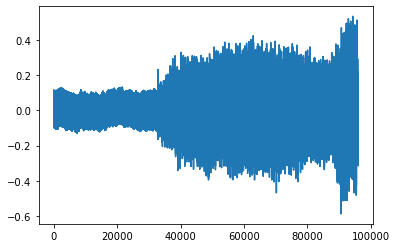

In [5]:
plt.plot(time_data[:fs])
wavf.write("tmp.wav",fs,time_data)

In [19]:
fs,time_data = wavf.read("npy_overlapping/MIC1.wav")
window_len=int(0.04*fs)
hop_len=window_len//2
time_data = time_data.reshape(-1,fs)
delta_sample = int(1*fs)
sample_start_idx = np.arange(0,delta_sample,hop_len)
#Adjust the sample_start_idx into suitable size so that we don't need to pad zero in the end
for i in range(len(sample_start_idx)-1,-1,-1):
    if(sample_start_idx[i]+window_len<delta_sample):
        sample_start_idx = sample_start_idx[0:i+1]
        break

In [20]:
normalize_gain = (np.iinfo(time_data.dtype).max +
                1.0) / time_data.max()
time_data = normalize_float(time_data, normalize_gain)

In [21]:
print(time_data.shape)

(18, 96000)


In [7]:
freq_data = []
for i in range(time_data.shape[0]):
    window_sample = np.stack([time_data[i,j:j+window_len] for j in sample_start_idx])
    f_FFT,fft_data = batch_windowed_fft(window_sample,fs)
    freq_data.append(fft_data)
freq_data = np.stack(freq_data)
print(freq_data.shape)

(18, 48, 1921)


In [8]:
rec_data = []
for i in range(freq_data.shape[0]):
    _,tmp = scipy.signal.istft(freq_data[i].T,fs,'hann',window_len,hop_len)
    rec_data.append(tmp)
rec_data = np.stack(rec_data)/np.stack(rec_data).max()
print(rec_data.shape)
rec_data = rec_data.reshape(-1,1)
wavf.write("tmp.wav",fs,rec_data)

(18, 90240)


In [64]:
window_len

3840

In [12]:
2*(883-1)

1764

In [28]:
from scipy import signal
import matplotlib.pyplot as plt
rng = np.random.default_rng()
fs = 1024
N = 10*fs
nperseg = 512
amp = 2 * np.sqrt(2)
noise_power = 0.001 * fs / 2
time = np.arange(N) / float(fs)
carrier = amp * np.sin(2*np.pi*50*time)
noise = rng.normal(scale=np.sqrt(noise_power),
                   size=time.shape)
x = carrier + noise

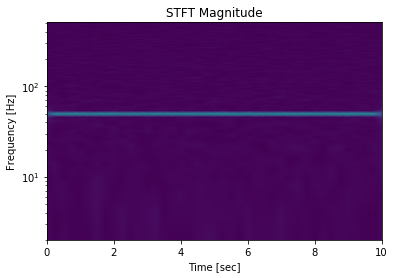

In [29]:
f, t, Zxx = signal.stft(x, fs=fs, nperseg=nperseg)
plt.figure()
plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=amp, shading='gouraud')
plt.ylim([f[1], f[-1]])
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.yscale('log')
plt.show()

In [30]:
print(Zxx.shape)

(257, 41)
